# Notebook on the (non) stability of some problem with matrices

First, Python's boilerplate

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
from IPython.display import display

sns.set(rc={"figure.figsize": (12, 12), "figure.dpi": 80}, style="whitegrid")
np.set_printoptions(precision=3)

We consider complex $3 \times 3$ matrices $M(t) \in \Complex^{3 \times 3 }$ with a real parameter $t \in \Reals$ of the following form, with general term $M(t)_{x,y} = e^{k_{x,y}ti}$

$$
\begin{bmatrix}
    e^{k_{1,1}ti}&e^{k_{1,2}ti}&e^{k_{1,3}ti}\\
    e^{k_{2,1}ti}&e^{k_{2,2}ti}&e^{k_{2,3}ti}\\
    e^{k_{3,1}ti}&e^{k_{3,2}ti}&e^{k_{3,3}ti}\\
\end{bmatrix}
$$

Coefficients $k_{x,y}$ constitue a $3 \times 3$ indexed sequence of real numbers, for instance $(1,2, \dots, 9)$ or $(\sqrt{1}, \sqrt{2}, \dots, \sqrt{19})$  the square roots of the first prime numbers.


In [2]:
# primes nombers
primes = [1, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
NDIM = 4


def gen_matrix(t=1, factors=None):
    """For factors [k1, ...k9], computes a matrix M with general term e^(ki * t * j) where 'j' is the imaginary number"""
    # default value
    if factors is None:
        factors = np.sqrt(primes[: NDIM**2])
    return np.exp(np.array(factors, dtype=np.clongdouble) * t * 1j).reshape(NDIM, NDIM)



We display for instance the matrix $M(1)$ below.

M as shape (4, 4) with values of type complex256. Content is as follows:


array([[ 0.54 +0.841j,  0.156+0.988j, -0.161+0.987j, -0.617+0.787j],
       [-0.88 +0.476j, -0.985-0.174j, -0.894-0.447j, -0.556-0.831j],
       [-0.346-0.938j,  0.083-0.997j,  0.623-0.782j,  0.755-0.656j],
       [ 0.98 -0.199j,  0.993+0.12j ,  0.963+0.271j,  0.841+0.542j]],
      dtype=complex256)

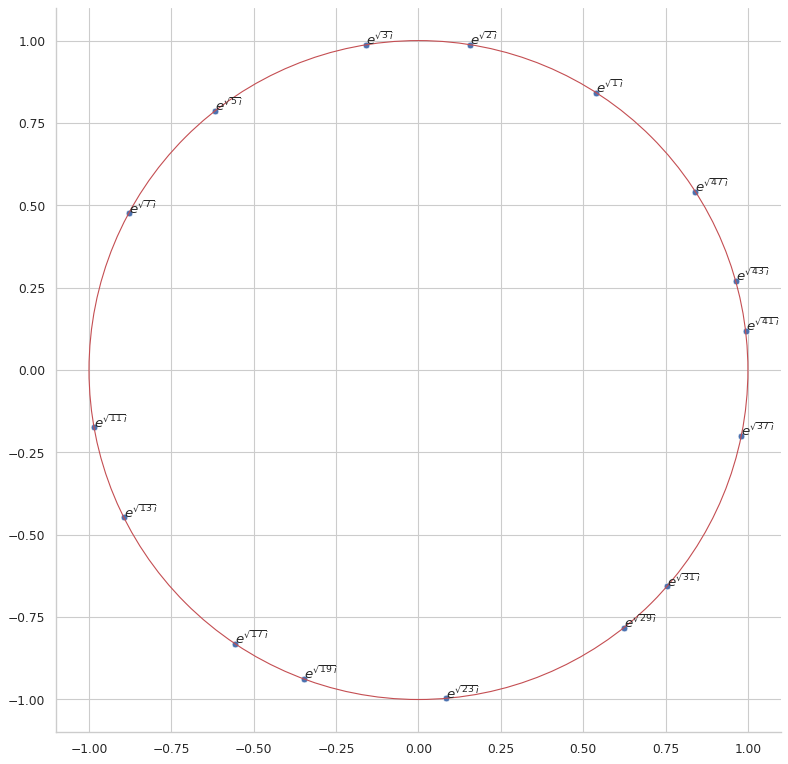

In [3]:
M = gen_matrix(1)
print(f"M as shape {M.shape} with values of type {M.dtype}. Content is as follows:")
display(M)

x_coords, y_coords = np.real(M.flatten()), np.imag(M.flatten())
ax = sns.scatterplot(x=x_coords, y=y_coords)
ax.set_aspect("equal", "box")
unit_circle = plt.Circle((0, 0), 1, edgecolor="r", fill=False)
ax.set(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
ax.add_patch(unit_circle)
for i in range(M.size):
    ax.annotate(f"$e^{{\sqrt{{{primes[i]}}}i}}$", (x_coords[i], y_coords[i]), rotation=0)
sns.despine()


Now, we extract the 3 eigenvalues and associated eigenvectors from a matrix.
Eigenvalues are sorted in decreasing order of their absolute values (a.k.a. modulus).
Eigenvectors are sorted accordingly.

In [4]:
def extract_eivs(m):
    """Returns complex eigenvalues in decreasing order of module and their eigenvectors"""
    vals, vecs = linalg.eig(m)
    order = np.argsort(-np.absolute(vals))
    
    # NOTE : mind the direction of vectors written as **columns** in vecs
    return np.take_along_axis(vals, order, axis=None), np.take_along_axis(vecs, order.reshape(1,-1), axis=1)


As an example, let's extract eigenvalues $v_i$ and vectors $\lambda_i$ from $M(1)$ and do some sanity checks :
- the eigenvectors are normalized
- eigenvectors $v_i$ are such that $\lambda_i v_i =  M v_i$

In [5]:
M_vals, M_vecs = extract_eivs(M)
print(f"Eigenvalues: {M_vals}")
print(f"Absolute values (sorted): {np.absolute(M_vals)}")
print(f"Eigenvectors:\n{M_vecs}")

# sanity check on each dimension
for n in range(NDIM):
    # chek that the n-th eigenvectors is related to the n-th eigenvalue
    redo = M @ M_vecs[:, n]
    norm = np.sum(np.absolute(M_vecs[:, n] * M_vecs[:, n]))
    assert np.allclose(redo, M_vals[n]*M_vecs[:, n])
    assert np.isclose(norm, 1.0)


Eigenvalues: [ 0.847+0.02j   0.018+0.597j  0.278-0.034j -0.124-0.156j]
Absolute values (sorted): [0.847 0.597 0.28  0.199]
Eigenvectors:
[[-0.405+0.169j -0.504-0.169j  0.013-0.364j -0.443-0.156j]
 [-0.137-0.515j  0.11 -0.406j  0.667+0.j     0.791+0.j   ]
 [ 0.619+0.j     0.595+0.j    -0.493+0.1j    0.087+0.155j]
 [ 0.222+0.301j -0.269+0.339j  0.195+0.363j -0.347+0.04j ]]


Now, with given a minimum time $t_1$, a maximum time $t_n$ and a number of points $n$, we generate a sequence of equally spaced points in time $T = (t_1, \dots, t_n)$, then we compute all $M(t_i)$ and their associated eigenvalues and vectors.

In [6]:
def get_all_eivs(mini, maxi, nb, factory = gen_matrix):
    """Returns a 3*nb array of eigenvalues : 1st row the largest modulus of each matrix, 2nd and 3rd, for nb parameters betwen mini an dmaxi

    ts: the points in time
    vals: the eigenvalues
    vecs: the eigenvectors
    """
    ts = np.linspace(mini, maxi, nb)
    res = [extract_eivs(factory(t)) for t in ts]
    # unzip
    vals, vecs = zip(*res)
    # vals = np.apply_along_axis(lambda t: extract_eivs(gen_matrix(t))[1], 0, ts.reshape(1, -1))
    # vecs = np.apply_along_axis(lambda t: extract_eivs(gen_matrix(t))[1], 0, ts.reshape(1, -1))
    return ts, np.array(vals), np.array(vecs)


For instance, for points in time $t \in (0, 2)$ we got the following datasets :

In [7]:
ts_2, vals_2, vecs_2 = get_all_eivs(0, 2, 2)
print(f"A sequence of length 2 of points in time\n{ts_2}")
print(f"A sequence of length 2 of {NDIM} eigenvalues\n{vals_2}")
print(f"A sequence of length 2 of {NDIM} eigenvectors, each one of dimension {NDIM}\n{vecs_2}")


A sequence of length 2 of points in time
[0. 2.]
A sequence of length 2 of 4 eigenvalues
[[ 4.000e+00+0.j    -2.220e-16+0.j     0.000e+00+0.j     0.000e+00+0.j   ]
 [-7.855e-02+1.57j   5.674e-01-0.511j  4.957e-01-0.104j -2.716e-01+0.234j]]
A sequence of length 2 of 4 eigenvectors, each one of dimension 4
[[[ 5.000e-01+0.j     8.660e-01+0.j    -1.110e-16+0.j
   -1.110e-16+0.j   ]
  [ 5.000e-01-0.j    -2.887e-01-0.j    -5.774e-01+0.j
   -5.774e-01+0.j   ]
  [ 5.000e-01-0.j    -2.887e-01-0.j     7.887e-01+0.j
   -2.113e-01+0.j   ]
  [ 5.000e-01-0.j    -2.887e-01-0.j    -2.113e-01+0.j
    7.887e-01+0.j   ]]

 [[-4.728e-01+0.181j  1.360e-01-0.216j  2.293e-01-0.066j
   -4.205e-01-0.436j]
  [ 5.652e-01+0.j    -3.328e-01+0.008j -3.716e-01-0.263j
    7.014e-01+0.j   ]
  [-4.117e-01+0.09j   8.497e-01+0.j    -5.055e-03-0.349j
   -1.298e-01-0.167j]
  [ 4.948e-01-0.044j -4.962e-02+0.315j  7.835e-01+0.j
    1.314e-01+0.281j]]]


For instance, we draw the absolute values on the interval $[0, 10]$ with precision $1/100$.

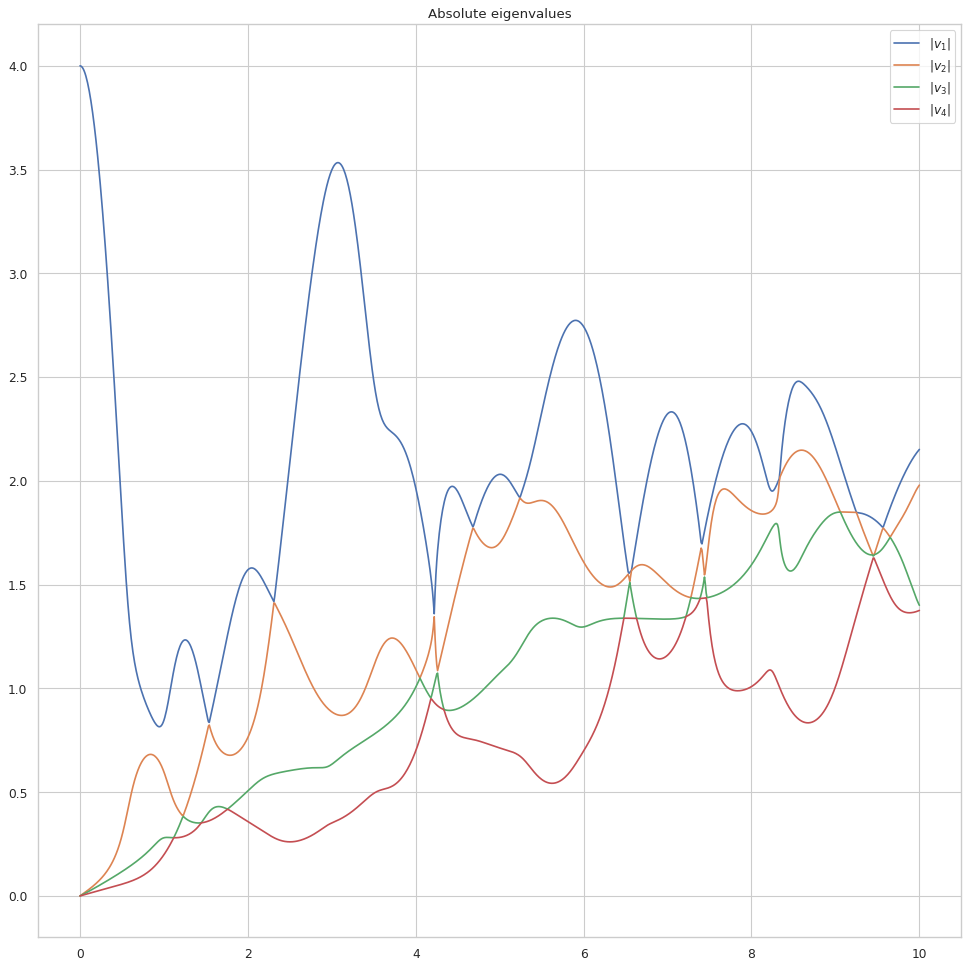

In [8]:
ts_100, vals_100, vecs_100 = get_all_eivs(0, 10, 1_001)
fig, ax = plt.subplots(constrained_layout=True)
for k in range(NDIM):
    # print(k, vals[:,k])
        # plt.xticks(ticks = np.linspace(MIN, MAX*np.pi/2, X_STEPS), labels = [f"${x}\\times \\frac{{\\pi}}{{2}}$" for x in range(X_STEPS)])
    k_th_vals = vals_100[:, k]
    sns.lineplot(x=ts_100, y=np.absolute(k_th_vals), label=f"$|v_{k+1}|$", ax=ax)
    # sns.lineplot(x=ts, y=np.angle(k_th_vals), label="angle", ax=ax)
    # sns.lineplot(x=ts, y=np.real(k_th_vals), label="real", ax=ax)
ax.set_title(f"Absolute eigenvalues")
plt.show()


From now on, we generate a larger dataset on the interval $[0, 10.000]$ with precision $1/100$, with 1 million matrixes and eigs.

In [9]:
T_MIN = 0
T_MAX = 10000
T_RES = 100
T_LEN = T_RES * (T_MAX - T_MIN) + 1
print(f"Generating {T_LEN} points between {T_MIN} and {T_MAX} with resolution {T_RES}")
ts, vals, vecs = get_all_eivs(T_MIN, T_MAX, T_LEN)
print(f"...done")


Generating 1000001 points between 0 and 10000 with resolution 100
...done


Let $\lambda_1(t)$, $\lambda_2(t)$ and $\lambda_3(t)$ the eigenvalues at point $t$ ordered decreasingly.
Let $v_1(t)$, $v_2(t)$ and $v_3(t)$ their respective eigenvectors.
We are interested into the subset of $I$ of  _interesting points_ such that $\lambda_1(t)$ and $\lambda_2(t)$ are close enough  for some fixed threshold value $k$, i.e., $I = \{t \mid ||\lambda_1(t)| - |\lambda_2(t)|| < k^{-1}\}$.


In [15]:
THRESHOLD = 10 * T_RES
K_MAX = 10
# I_filter = np.abs(np.absolute(vals[:, 0]) - np.absolute(vals[:, 1])) < 1 / THRESHOLD
I_filter = np.isclose(np.absolute(vals[:, 0]), np.absolute(vals[:, 1]), atol=1 / THRESHOLD, rtol=0.0)
I_points = ts[I_filter]
I_idx = np.arange(len(ts))[I_filter]
print(f"Total {len(I_points)} interesting points")
print(
    f"First {K_MAX} interesting points with resolution {1/T_RES} at threshold {1/THRESHOLD} (k = {THRESHOLD}) are at times\n{I_points[:K_MAX]}"
)
diffs = np.absolute(vals[I_filter, 0]) - np.absolute(vals[I_filter, 1])
print(f"First {K_MAX} smallest differences between 1st and 2nd eigs are\n{diffs[:K_MAX]}")
order = np.argsort(-1 / diffs)
top_k = np.concatenate((I_points[order].reshape(-1, 1), diffs[order].reshape(-1, 1)), axis=1)[:K_MAX]
print(f"Top-{K_MAX} differences are at points\n{top_k}")  # {ts[order][:K_MAX]} ({diffs[order][:K_MAX]})
print("Done")


Total 1688 interesting points
First 10 interesting points with resolution 0.01 at threshold 0.001 (k = 1000) are at times
[ 9.25 19.9  21.11 28.8  33.1  34.81 41.12 49.6  51.8  51.88]
First 10 smallest differences between 1st and 2nd eigs are
[0.    0.001 0.001 0.001 0.    0.001 0.    0.001 0.    0.001]
Top-10 differences are at points
[[4.722e+03 4.752e-08]
 [9.017e+03 1.188e-07]
 [5.074e+03 6.094e-07]
 [2.472e+03 1.519e-06]
 [8.602e+03 1.643e-06]
 [4.301e+03 3.108e-06]
 [9.211e+03 4.126e-06]
 [6.191e+03 5.660e-06]
 [9.089e+03 6.068e-06]
 [1.420e+03 6.475e-06]]
Done


The inverse of the difference can be drawn, so pikes highlight points $t_x$ where $|\lambda_1(t_x)|$ and $|\lambda_2(t_x)|$ are close.

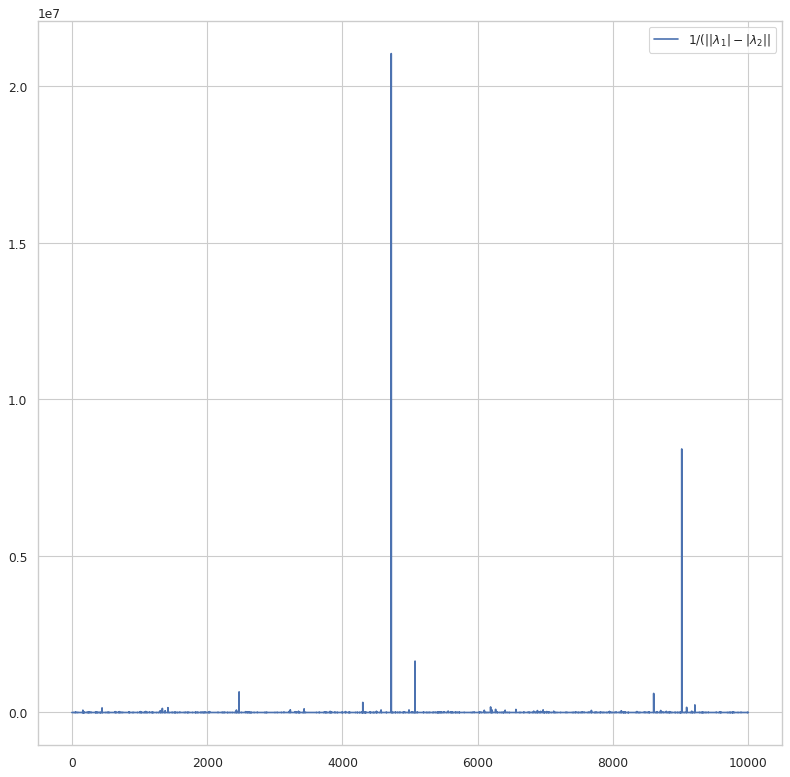

In [11]:
sns.lineplot(
    x=ts,
    y=np.absolute(1 / np.absolute(np.absolute(vals[:, 0]) - np.absolute(vals[:, 1]))),
    label=f"$1/(||\lambda_1| - |\lambda_2||$",
)
plt.show()


Now, for matrices $\{ M(t_x) | t_x \in I\}$, we compute the following _ratio_ for all dimensions $k \in \{1,2,3\}$ 

$$ \frac{x^k_1}{x^k_2}. \frac{e^{\theta_1i}}{e^{\theta_2i}}$$

where $\lambda_1(t_x) = r_1(t_x).e^{\theta_1(t_x) i}$ is the largest eigenvalue, $\lambda_2(t_x) = r_2(t_x).e^{\theta_2(t_x) i}$ is the second one, $v_1(t_x) = (x^1_1(t_x), x^2_1(t_x), x^3_1(t_x))$ is the first eigenvector and $v_2(t_x) = (x^1_2(t_x), x^2_2(t_x), x^3_2(t_x))$ is the second one.

In [16]:
print(f"Eigenvalues at interesting {len(vals[I_filter])} points t_x:\n{vals[I_filter, 0:2]}")
print(f"Differences\n{np.absolute(vals[I_filter, 0]) - np.absolute(vals[I_filter, 1])}")

ratios = (vecs[I_filter, :, 0] * np.exp(np.angle(vals[I_filter, 0]).reshape(-1,1)) * 1j) / (vecs[I_filter, :, 1] * np.exp(np.angle(vals[I_filter, 1]).reshape(-1,1)) * 1j)
print(f"Ratios\n{ratios}")


Eigenvalues at interesting 1688 points t_x:
[[-1.827-0.276j  1.784-0.483j]
 [-0.828-1.845j  1.08 +1.708j]
 [-0.345+1.884j  1.816+0.606j]
 ...
 [ 0.726+2.143j  1.714-1.476j]
 [ 1.546+1.5j    0.329-2.128j]
 [ 1.504-1.287j -1.907+0.527j]]
Differences
[0.    0.001 0.001 ... 0.    0.001 0.001]
Ratios
[[-4.836e-01-5.035e-01j -2.889e-02+3.032e-02j  3.712e-02-6.508e-03j
  -2.750e-02-1.413e-02j]
 [-1.189e-02+1.081e-02j  2.446e-03+6.018e-02j -2.264e-02+2.152e-02j
   5.854e-02-6.455e-02j]
 [ 3.222e+00+3.109e+00j -1.008e+00+2.089e+00j  5.845e+00+5.139e+00j
  -7.457e-01-2.745e+00j]
 ...
 [-1.256e+00+8.084e-01j  3.905e+00-1.838e+01j -9.579e-01-5.598e+00j
  -8.154e+00+1.516e+01j]
 [-8.755e+00+3.088e+00j  7.095e+00+2.643e-01j  3.061e+00+2.924e+00j
   1.534e+01-9.490e+00j]
 [ 1.385e-02-9.916e-03j -1.593e-02+2.455e-03j -3.198e-02+2.680e-03j
  -3.151e-02+5.692e-02j]]


Now, we draw the 1st ratios in the complex plane.

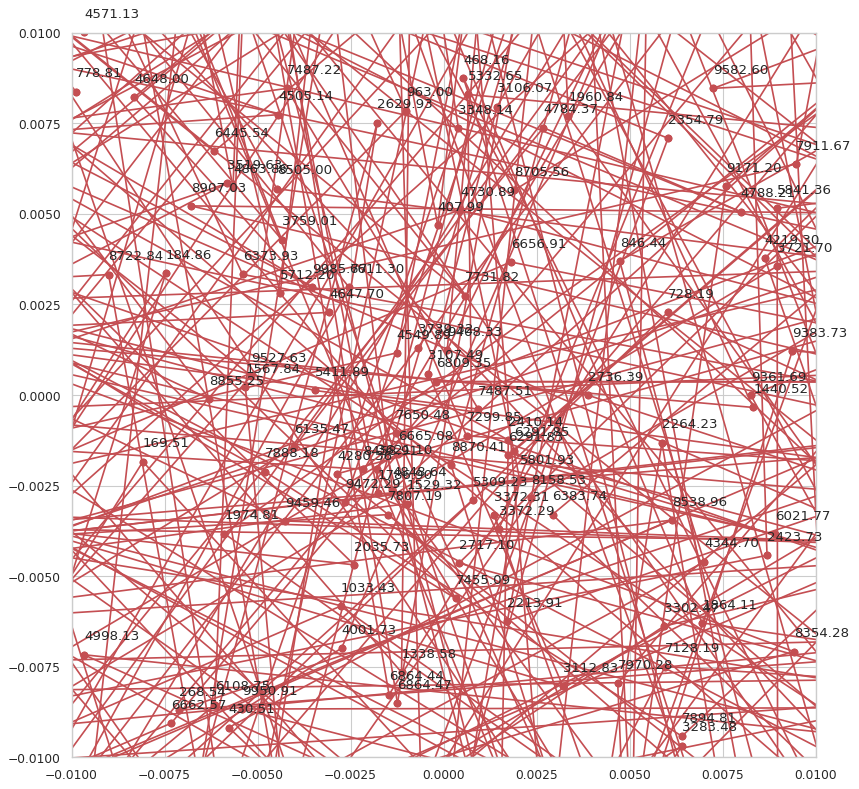

In [19]:
# first component only
# arr = ratios[:,1]

# plot = sns.scatterplot(x = np.real(arr), y=np.imag(arr))
# for i, tx in enumerate(ts[I_filter]):
#     plot.annotate(str(tx), (np.real(arr[i]), np.imag(arr[i])), rotation=0)

arr = ratios[:, 1]
ax = plt.subplot()
for i, tx in enumerate(ts[I_filter][:-1]):
    # p1 = np.real(arr[i]), np.imag(arr[i])
    # p2 = np.real(arr[i+1]), np.imag(arr[i+1])
    xs = np.real(arr[i]), np.real(arr[i + 1])
    ys = np.imag(arr[i]), np.imag(arr[i + 1])
    ax.plot(xs, ys, "ro-")
    ax.annotate(f"{tx:.2f}\n", (xs[0], ys[0]))
ax.annotate(f"{ts[I_filter][-1]:.2f}", (xs[1], ys[1]))

X_LIM = 0.01
if X_LIM is not None:
    ax.set_xlim(-X_LIM, +X_LIM)
    ax.set_ylim(-X_LIM, +X_LIM)
plt.show()
